In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from sklearn.utils import shuffle
import cv2
import os
import keras


2024-11-22 04:30:21.667963: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 04:30:21.727413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 04:30:22.490865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df=pd.read_csv("/raid/coss35/nahyun/study/dataset/ageutk_full.csv")

In [3]:
df.loc[(df.age<=49) & (df.age>=20), ['files','age','gender']]

,files,age,gender
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0
1,22_1_1_20170112233644761.jpg.chip.jpg,22,1
2,21_1_3_20170105003215901.jpg.chip.jpg,21,1
3,28_0_0_20170117180555824.jpg.chip.jpg,28,0
5,44_0_3_20170119201022260.jpg.chip.jpg,44,0
...,...,...,...
23152,30_0_4_20170103235622469.jpg.chip.jpg,30,0
23153,38_1_2_20170109132801338.jpg.chip.jpg,38,1
23159,26_1_0_20170111182452795.jpg.chip.jpg,26,1
23163,41_0_0_20170109012220690.jpg.chip.jpg,41,0


In [4]:
data=df['files']
target=df['gender']

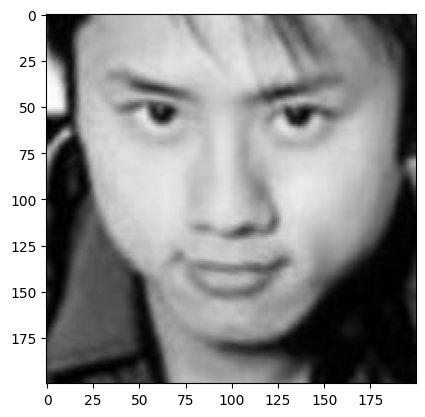

In [5]:
# 데이터프레임에서 파일 경로 가져오기
data = df['files']  # pandas.Series
target = df['gender']

# 첫 번째 파일 경로 가져오기
base_path = "/raid/coss35/nahyun/study/dataset/UTKFace/UTKFace/UTKFace/"
image_path = base_path + data.iloc[0] # Series에서 안전하게 첫 번째 값 가져오기

# 이미지 로드
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 이미지 로드 확인
#print(f"Image type: {type(image)}")
image = image.astype(np.float32) / 255.0
plt.imshow(image, cmap="gray")
plt.show()


In [6]:
xtrain=[]

# 첫 번째 파일 경로 가져오기
base_path = "/raid/coss35/nahyun/study/dataset/UTKFace/UTKFace/UTKFace/"

for i in range(len(data)):
    image_path=base_path+data.iloc[i]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.0
    xtrain.append(image)

x_img_np = np.array(xtrain) 

In [7]:
target=target.to_numpy()

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_img_np, target, test_size=0.3, stratify=target) #random_state=2018)

In [9]:
x_train = x_train.reshape(( -1,200, 200, 1)).astype('float32') / 255.0
x_test = x_test.reshape((-1,200, 200, 1)).astype('float32') / 255.0

In [51]:
# Model Creation
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200,200,1)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

---

In [52]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_test, y_test))

# Evaluate the model

Epoch 1/5
254/254 [==============================] - 718s 3s/step - loss: 0.6920 - accuracy: 0.5240 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 2/5
254/254 [==============================] - 688s 3s/step - loss: 0.6917 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 3/5
254/254 [==============================] - 683s 3s/step - loss: 0.6919 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 4/5
254/254 [==============================] - 686s 3s/step - loss: 0.6919 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 5/5
254/254 [==============================] - 692s 3s/step - loss: 0.6917 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270


---
### ResNet50 + GrandCAM

In [10]:
from tensorflow.keras.applications import resnet50,ResNet50
from tensorflow.keras.preprocessing import image 

model=ResNet50(include_top=False,pooling='avg',input_shape=(200,200,3),weights='imagenet')
model.trainable=False
#model.summary()

2024-11-22 04:31:08.373739: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

x_train_rgb = np.repeat(x_train, 3, axis=-1)  # Replicate the single channel 3 times
x_test_rgb = np.repeat(x_test, 3, axis=-1)

# Preprocess labels
# Convert labels for binary classification
input_y = np.where(y_train > 0, 1, 0)  # Convert labels to 0 or 1
test_y = np.where(y_test > 0, 1, 0)    # Convert labels to 0 or 1

# Preprocess inputs (if needed)
input_y = np.expand_dims(input_y, axis=-1)  # Ensure shape is correct
test_y = np.expand_dims(test_y, axis=-1)

# Update model layer design
inputs = Input(shape=(200, 200, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)  # Use preprocess_input for ResNet50
x = model(x, training=False)
x = Flatten()(x)  # Flatten for fully connected layer
outputs = Dense(2, activation='relu')(x)  # 2-class softmax classifier
model_res = tf.keras.Model(inputs, outputs)

In [13]:
# 모델 컴파일 진행 - 아까와 달리 categorical_crossentropy 사용 > label이 숫자형 데이터이므로
model_res.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [14]:
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# 모델 fitting
model_res.fit(x_train_rgb, input_y, epochs = 10, validation_data=(x_test_rgb, test_y), batch_size= 256)

Epoch 1/10
24/64 [==========>...................] - ETA: 18:31 - loss: 3.9501 - accuracy: 0.5337

KeyboardInterrupt: 

In [ ]:
model_res.save("ResNet_Transfor_learning.h5")

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import decode_predictions

for i in range(5):

  inputs = x_test[i]
  inputs = tf.expand_dims(inputs, axis=0)
  x = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(inputs)
  x = tf.keras.applications.resnet50.preprocess_input(x) 

  preds = base_model.predict(x)  # ResNet Model의 예측진행

  # 예측 실행
  fig= plt.figure(figsize=(3,3))
  plt.title(decode_predictions(preds, top=1)[0][0][1])# 타이틀에 예측 명 1순위를 넣는다.
  plt.imshow(x_test[i])	# 이미지는 
  plt.show()

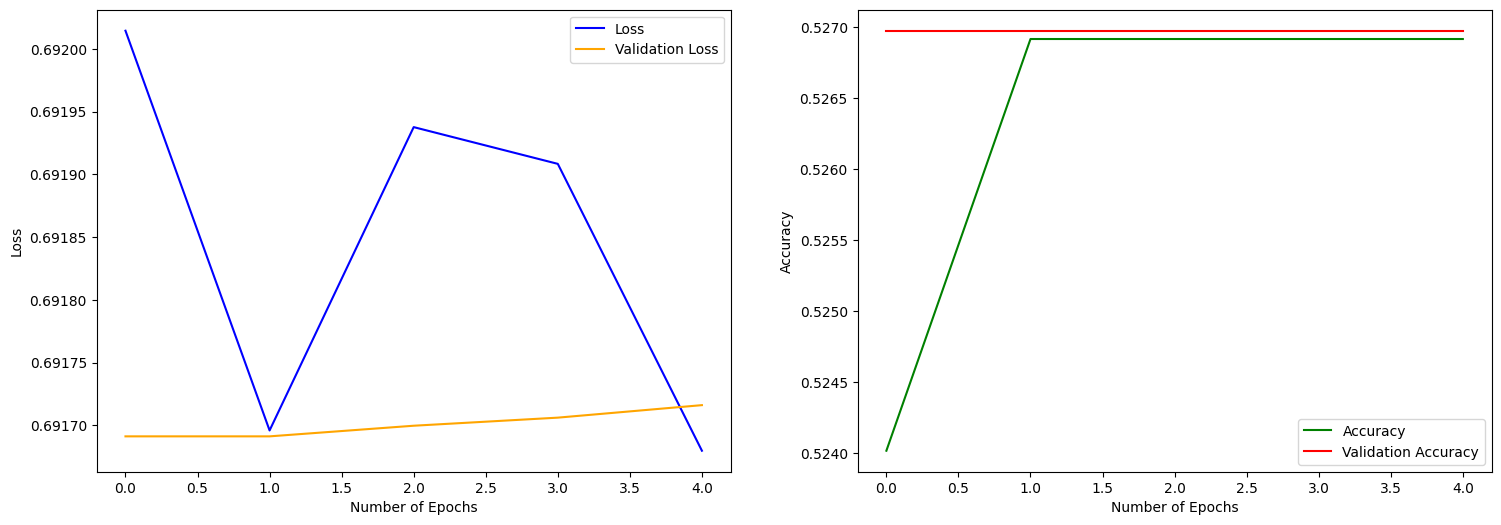

In [54]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="blue", label = "Loss")
plt.plot(history.history['val_loss'], color="orange", label = "Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color="green", label = "Accuracy")
plt.plot(history.history['val_accuracy'], color="red", label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.show()

In [53]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

218/218 [==============================] - 77s 354ms/step - loss: 0.6917 - accuracy: 0.5270


In [ ]:
model.save("CNN_model.h5")

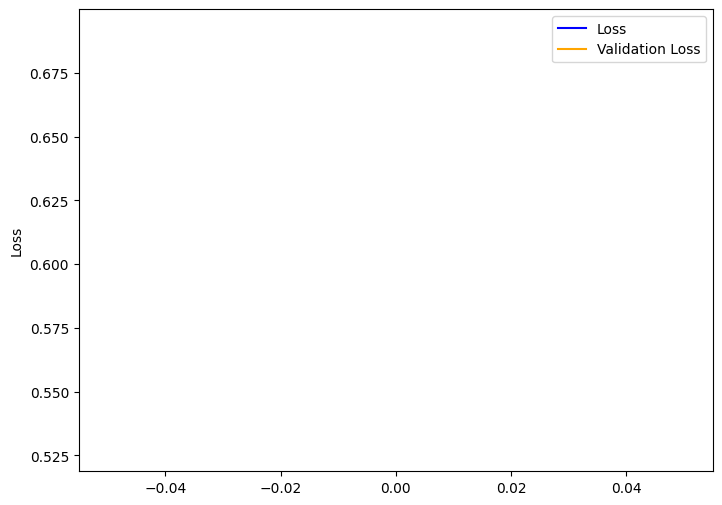

In [32]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(test_acc, color="blue", label = "Loss")
plt.plot(test_loss, color="orange", label = "Validation Loss")
plt.ylabel("Loss")
plt.legend()


plt.show()

In [40]:
from keras.models import load_model

model=load_model("CNN_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

In [44]:
import cv2
import numpy as np

# 이미지 로드 (그레이스케일로 로드)
image_path = "/raid/coss35/nahyun/study/dataset/test.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 이미지 크기 확인 및 리사이징
target_size = (200, 200)  # 모델에서 기대하는 입력 크기
image_resized = cv2.resize(image, target_size)

# 차원을 추가하여 (200, 200) -> (200, 200, 1)로 만듦
image_resized = np.expand_dims(image_resized, axis=-1)

# 배치 차원을 추가하여 (200, 200, 1) -> (1, 200, 200, 1)로 만듦
image_resized = np.expand_dims(image_resized, axis=0)

# 정규화 (픽셀 값을 0~1 사이로 스케일링)
image_resized = image_resized.astype(np.float32) / 255.0

In [45]:
# Make predictions on the test set
predictions = model.predict(image_resized)

# 0 : man, 1 : female
# For binary classification, you can use a threshold of 0.5
pred_classes = (predictions > 0.5).astype(int).flatten()  # Flatten to 1D array
print(pred_classes)

1/1 [==============================] - 0s 32ms/step
[0]
